In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
sns.set(rc={'figure.figsize':(15.7,8.27)})

import warnings
warnings.filterwarnings("ignore")

In [2]:
target = 'class'
names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', target]
data = pd.read_csv('car.data', header=None, names=names)
target_categories = data[target].value_counts().index
target_categories

Index(['unacc', 'acc', 'good', 'vgood'], dtype='object')

In [3]:
data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


# EDA

In [5]:
def number_eda(column):
    fig, ax =plt.subplots(2,2)
    sns.kdeplot(data[column], ax=ax[0,0], bw=1)
    for cat in target_categories:
        sns.kdeplot(data[data[target] == cat][column], ax=ax[0,1], bw=1)
    sns.boxplot(data[column], ax=ax[1,0])
    sns.boxplot(y=target, x=column, data=data, ax=ax[1,1])
    fig.show()
    display(Markdown('## {}'.format(column)))
    value_counts = data.groupby(target)[column].value_counts()
    table = pd.DataFrame()
    hist_bins = np.histogram(data[column])[1]
    for cat in target_categories:
        table[cat] = np.histogram(data[data[target] == cat][column], bins=hist_bins)[0]
    table['total'] = table[target_categories].sum(axis=1)
    table.index = pd.Series(hist_bins[:-1])
    display(table)
    plt.show()


def object_eda(column):
    fig, ax =plt.subplots(1,2)
    sns.countplot(x=column, data=data, ax=ax[0])
    sns.countplot(x=column, data=data, hue=target, ax=ax[1])
    fig.show()
    display(Markdown('## {}'.format(column)))
    value_counts = data.groupby(target)[column].value_counts()
    table = value_counts.unstack(level=0)
    table = table.fillna(0)
    table['total'] = table[target_categories].sum(axis=1)
    table.index.name = None
    table.columns.name = None
    table.sort_values(by=['total'], ascending=False, inplace=True)
    display(table)
    plt.show()
def feature_eda(column):
    if (pd.api.types.is_numeric_dtype(data[column].dtype)):
        number_eda(column)
    else:
        object_eda(column)
    



## buying

,acc,good,unacc,vgood,total
high,108.0,0.0,324.0,0.0,432.0
low,89.0,46.0,258.0,39.0,432.0
med,115.0,23.0,268.0,26.0,432.0
vhigh,72.0,0.0,360.0,0.0,432.0


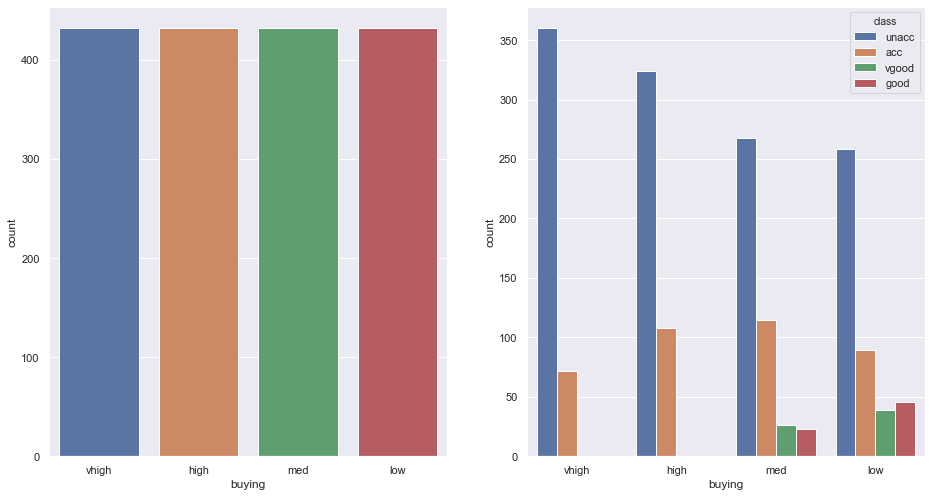

## maint

,acc,good,unacc,vgood,total
high,105.0,0.0,314.0,13.0,432.0
low,92.0,46.0,268.0,26.0,432.0
med,115.0,23.0,268.0,26.0,432.0
vhigh,72.0,0.0,360.0,0.0,432.0


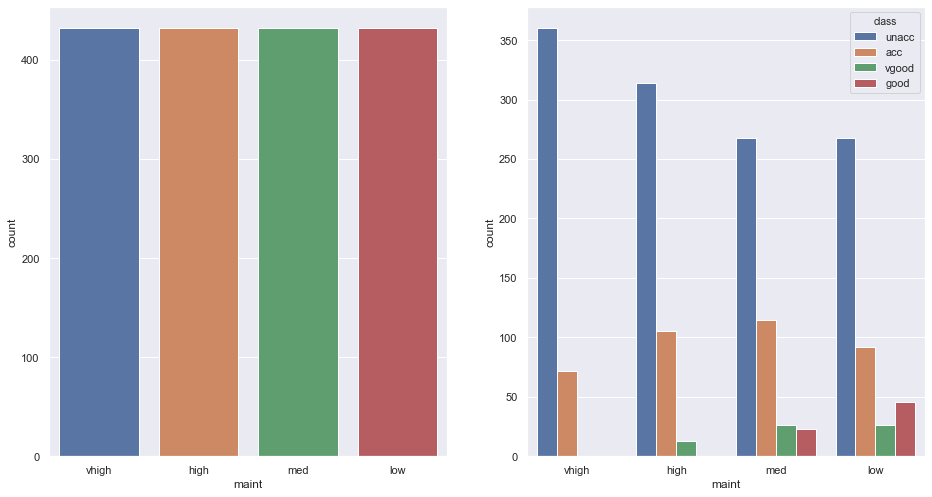

## doors

,acc,good,unacc,vgood,total
2,81,15,326,10,432
3,99,18,300,15,432
4,102,18,292,20,432
5more,102,18,292,20,432


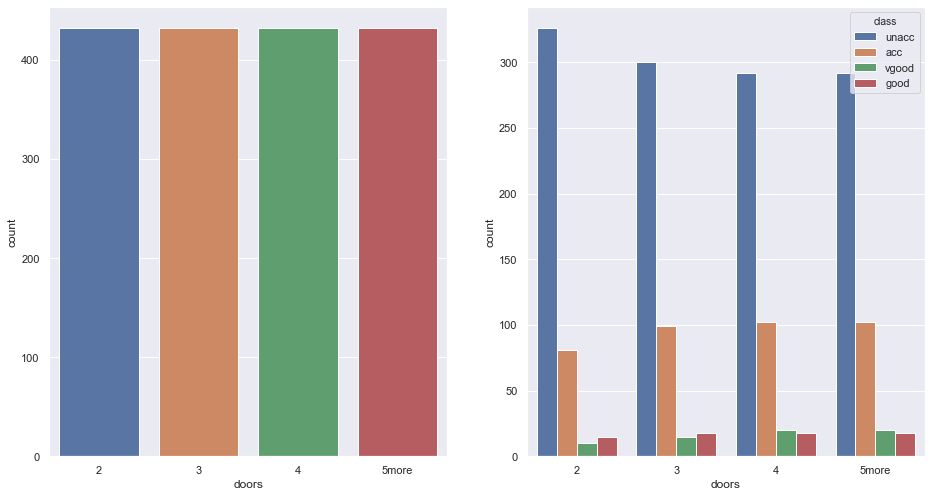

## persons

,acc,good,unacc,vgood,total
2,0.0,0.0,576.0,0.0,576.0
4,198.0,36.0,312.0,30.0,576.0
more,186.0,33.0,322.0,35.0,576.0


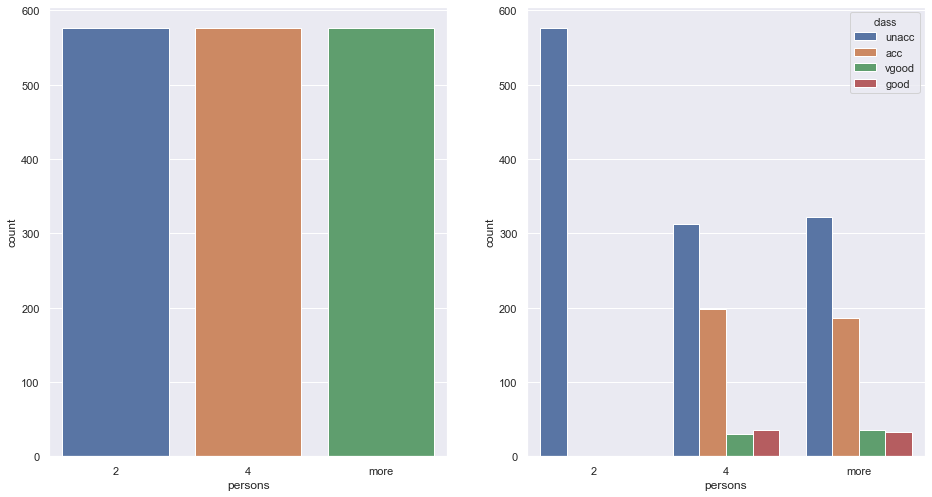

## lug_boot

,acc,good,unacc,vgood,total
big,144.0,24.0,368.0,40.0,576.0
med,135.0,24.0,392.0,25.0,576.0
small,105.0,21.0,450.0,0.0,576.0


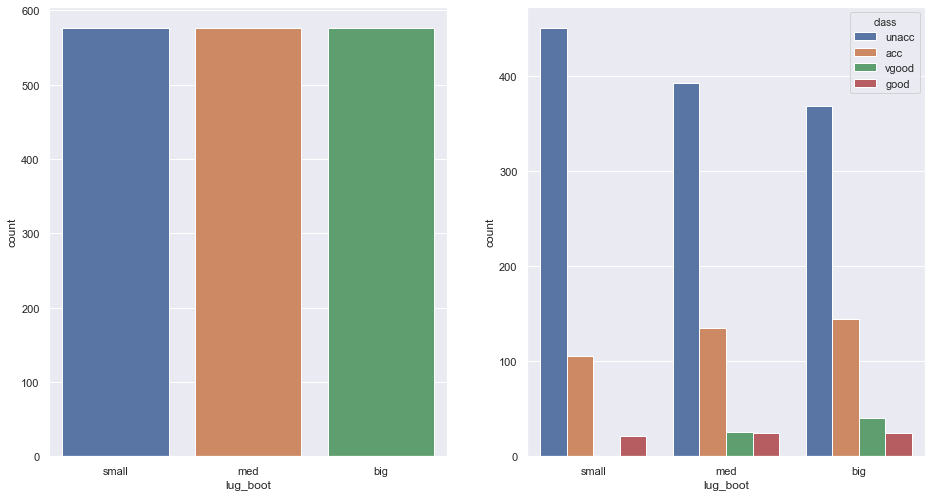

## safety

,acc,good,unacc,vgood,total
high,204.0,30.0,277.0,65.0,576.0
low,0.0,0.0,576.0,0.0,576.0
med,180.0,39.0,357.0,0.0,576.0


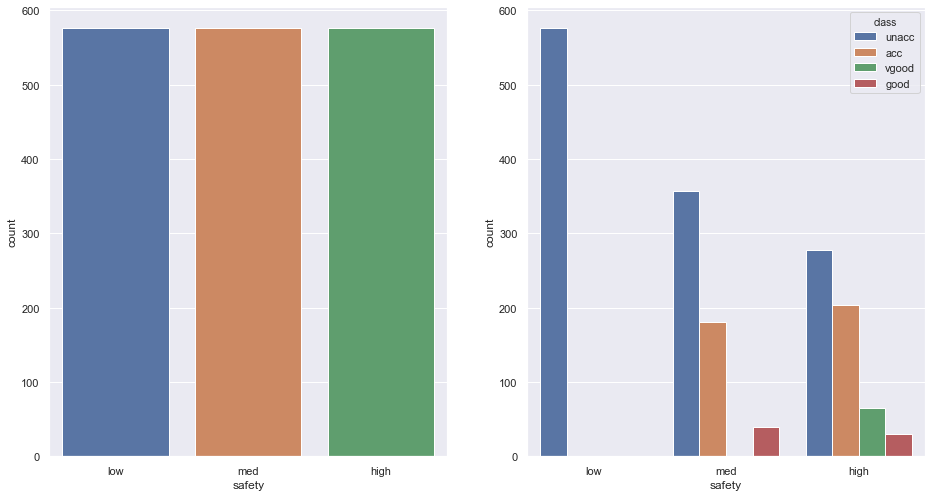

## class

,acc,good,unacc,vgood,total
unacc,0.0,0.0,1210.0,0.0,1210.0
acc,384.0,0.0,0.0,0.0,384.0
good,0.0,69.0,0.0,0.0,69.0
vgood,0.0,0.0,0.0,65.0,65.0


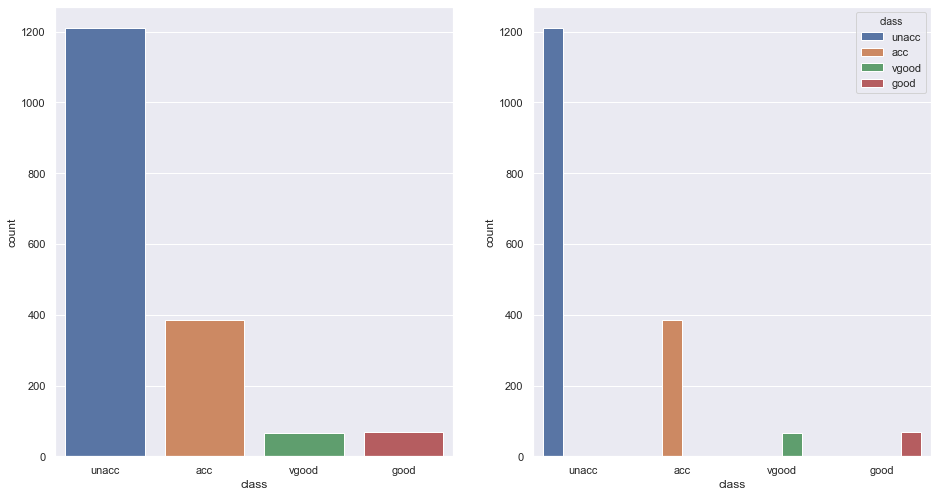

In [6]:
for column in data.columns:
    feature_eda(column)

In [208]:
from sklearn.base import BaseEstimator, TransformerMixin

def data_split_train_test(X, y, test_size=0.3, train_size=None):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        train_size=train_size,
        stratify=y,
        random_state=0)
    return X_train, X_test, y_train, y_test

def quality_report(prediction, actual):
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual, average='macro')
    recall = recall_score(prediction, actual, average='macro')
    f1 = f1_score(prediction, actual, average='macro')
    quality_list = [acc, precision, recall, f1]
    return quality_list

quality = pd.DataFrame(
    [],
    columns=["Accuracy", "Precision", "Recall", "F1"],
)

class Empty(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        self.columns = X.columns
        return self
    def transform(self, X):
        return X
    def fit_transform(self, X, y=None):
        return X
    def get_feature_names(self):
        return self.columns
    
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns 

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

def make_examine(X, y, X_preproc, y_prep, train_size=None):
    pX = X_preproc.transform(X)
    py = y_prep.transform(y)
    def examine(tag, X_make_prep, model):
        X_train, X_test, y_train, y_test = data_split_train_test(pX, py, train_size=train_size)
        X_prep = X_make_prep()
        X_p = X_prep.fit_transform(X_train)
        model.fit(X_p, y_train)
        pred = model.predict(X_prep.transform(X_test))
        quality.loc[tag, :] = quality_report(pred, y_test)
    return examine

# ML

In [209]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

X = data.drop('class', axis=1)
y = data['class']

target_encoder = LabelEncoder().fit(y)

In [210]:
examine = make_examine(X, y, Empty(), target_encoder)

In [222]:
examine('Random forest', lambda: MultiColumnLabelEncoder(), RandomForestClassifier(random_state=42))
quality


,Accuracy,Precision,Recall,F1
Random forest,0.963391,0.921328,0.969206,0.942398


In [214]:
from sklearn.model_selection import GridSearchCV
import pickle
import os

def search_params():
    cached_filename = 'grid.pickle'
    if os.path.isfile(cached_filename):
        with open(cached_filename, 'rb') as handle:
            return pickle.load(handle)
    X_prep = MultiColumnLabelEncoder().fit_transform(X)
    y_prep = target_encoder.transform(y)
    _range = np.logspace(-5, 4, 10)
    kernel_range=np.array(['linear', 'poly', 'rbf', 'sigmoid'])
    parameters = {
        'n_estimators': range(6, 100, 6),
        'max_depth': range(2, 20, 2),
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion':['gini', 'entropy']
    }
    grid = GridSearchCV(RandomForestClassifier(), param_grid=parameters, scoring='accuracy', cv=5, verbose=5, n_jobs=-1)
    grid.fit(X_prep, y_prep)
    with open(cached_filename, 'wb') as handle:
        pickle.dump(grid, handle)
    return grid

grid = search_params()



Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | 

In [218]:
p = grid.best_params_
p

{'criterion': 'gini',
 'max_depth': 14,
 'max_features': 'sqrt',
 'n_estimators': 84}

In [224]:
tuned_clf = RandomForestClassifier(random_state=42, 
                                   criterion=p['criterion'], 
                                   max_depth=p['max_depth'], 
                                   max_features=p['max_features'], 
                                   n_estimators=p['n_estimators'])
examine('Tuned random forest', lambda: MultiColumnLabelEncoder(), tuned_clf)
quality

,Accuracy,Precision,Recall,F1
Random forest,0.963391,0.921328,0.969206,0.942398
Tuned random forest,0.969171,0.925474,0.97382,0.945474


# Feature importance

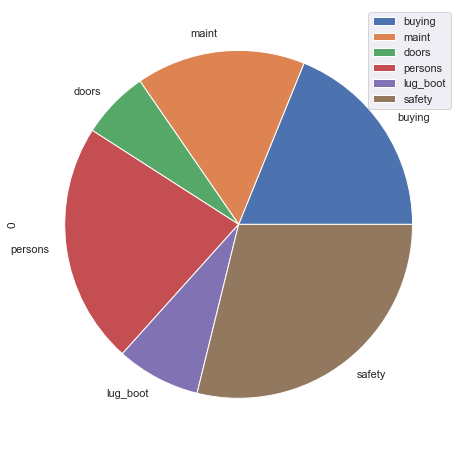

In [249]:
pd.DataFrame(tuned_clf.feature_importances_, index=X.columns).plot.pie(y=0, figsize=(8, 8))